# Mphasis HyperGraf KYC based Customer Segmentation

Customer segmentation aggregates the data captured in the KYC details and creates customer groups. The KYC data comes in various categories such as  Geographic, Demographic, Behavior and Financial variables.  This solution leverages machine learning to identify patterns in the data and segment the customers. These segments can be utilized for marketing analytics and campaigns.

### Prerequisite

The kernel comes pre-installed with the required packages. Else ensure to have the following Python Packages in your environment at minimum:

    - numpy
    - pandas
    - sklearn

 ### Contents

1. [Importing libraries for runtime](#Importing-libraries-for-runtime)
1. [Model](#Model)
1. [Batch Transform](#Batch-Transform)
1. [Output](#Output)
1. [Interpretation](#Interpretation) 
1. [Endpoint](#Endpoint)

## Importing libraries for runtime

In [44]:
import pandas as pd
import boto3
import re

### Input Format
Input file from sage_maker should be of the form .zip and should contain two files namely "Input.csv" and "parameters.json". 

All the data must be sent in Input.csv, where as all the parameter inputs for clustering algorithm must be sent through parameters.json files.

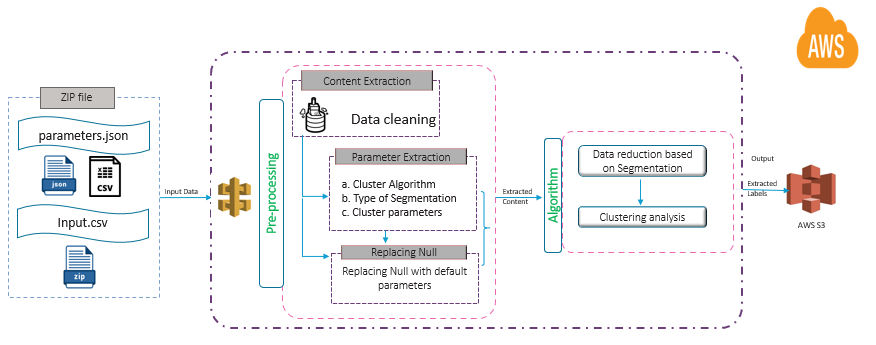

* Max number of samples = 100000
* Min number of samples = 1000

Type of clustering: 
 Default = hdbscan
*	hdbscan
*	kmeans
*	kmodes


Type of segmentation:
Default = Combined
*	Geographic segmentation
*   Demographic segmentation
*	Behavior segmentation
*	Financial segmentation
*	Combined

Recommended clustering parameters for different clustering:
Note: 
*	hdbscan: (Integer)
•	min_cluster_size = (Default  = 1000)
•	min_samples  = (Default = 80)
*	kmeans: (Integer)
•	n_clusters = (Default  = 5)
*	kmodes: (Integer)
•	n_clusters = (Default = 5)


##### All the attributes must be one of below mentioned: 

<b> Note: if other columns with different names are added they will be not considered </b>
•	'customer_code': Unique ID for customers

###### Columns allowed for Geographic segmentation:
(any two from the following needs to be present for Geographic segmentation)
*	'area_type': Type of area (Categorical variable)
*	'new_territory': yes or no (Categorical variable)
*	'country': Country code (US) (Categorical variable)
*	'city': City code (Ex: NY) (Categorical variable)
*	'population_density': Density of population (Numeric variable) 

###### Columns allowed for Demographical segmentation:
(any two from the following needs to be present for Demographical segmentation)
*	'age': Age in years/month (Numeric variable)
*	'gender': M/F/Others/Unknown (Categorical variable)
*	'race': Race (Categorical variable)
*	'religion': Religion (Categorical variable)
*	'years_of_education': In years/months (Numeric variable)
*	'income': Gross income/ Avg.income (Numeric variable)

###### Columns allowed for Behavioral segmentation:
(any two from the following needs to be present for Behavioral segmentation)
*	'customer_seniority': Seniority of customers in years/Months (Numeric variable)
*	'customer_status': Active customer (1)/ Inactive customer(0)/…. (Categorical variable)
*	'new_customer': New customer or not 0/1 (Categorical variable)
*	'employee': Person is an existing employee or not ex: current_emp (1)/ previous_emp(0)/ not_emp(-1)(Categorical variable)

###### Columns allowed for Financial segmentation:
(any two from the following needs to be present for Financial segmentation)
*	'loan_amount': Loan Amount (Numeric variable)
*	'credit_rating': Credit card Rating (Categorical variable)
*	'yearly_spend': Amount spend in a (year/month) (Numeric variable variable)
*	'income': Amount of money earned (Year/month) (Numeric variable)

<b> Note: 
 Ensure Content-Type is 'application/zip' and contain both 'Input.csv' and 'parameters.json' files.
</b>

In [45]:
input_df  = pd.read_csv("Input.csv")
input_df.head()

,customer_code,age,customer_seniority,Income,gender,customer_status
0,816978,55,80,67804.53,M,1
1,154073,50,187,109185.81,M,0
2,739359,48,91,100030.77,F,1
3,482251,23,132,131938.74,M,1
4,922105,24,48,41739.18,F,1


## Model

### De-Serializing model

The serialzed Pickle file containing the trained model must be loaded for customer segmentation from the input variables.

The model is de-serialized to a Python object.

<b> Note: 
    Ensure the trained model exist in sagemaker container and is placed in ../model directory.
</b>

In [46]:
model_package_arn = 'arn:aws:sagemaker:us-east-2:786796469737:model-package/mphasis-marketplace-customer-segmentation-v3'

In [47]:
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = sage.Session()

In [48]:
model = ModelPackage(model_package_arn=model_package_arn,
                    role = role,
                    sagemaker_session = sagemaker_session)

## Batch Transform


In [49]:
import json 
import uuid


transformer = model.transformer(1, 'ml.m5.large')
transformer.transform('s3://mphasis-marketplace/Mphasis-customer-segmentation/Input/Input_1.zip', content_type='application/zip')
transformer.wait()
#transformer.output_path
print("Batch Transform complete")
bucketFolder = transformer.output_path.rsplit('/')[3]

............... * Serving Flask app "serve" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 304-485-506
2020-05-05T04:00:39.633:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD

169.254.255.130 - - [05/May/2020 04:00:39] "#033GET /ping HTTP/1.1#033" 200 -
169.254.255.130 - - [05/May/2020 04:00:39] "#033GET /execution-parameters HTTP/1.1#033" 404 -
['hdbscan', 'Demographical segmentation', [1000, 80]]
hdbscan
Demographical segmentation
[1000, 80]
169.254.255.130 - - [05/May/2020 04:00:39] "#033GET /ping HTTP/1.1#033" 200 -
169.254.255.130 - - [05/May/2020 04:00:39] "#033GET /execution-parameters HTTP/1.1#033" 404 -
['hdbscan', 'Demographical segmentation', [1000, 80]]
hdbscan
Demographical segmentation
[1000, 80]
/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobli

In [51]:
#print(s3bucket,s3prefix)
s3_conn = boto3.client("s3")
bucket_name="sagemaker-us-east-2-786796469737"
with open('output.csv', 'wb') as f:
    s3_conn.download_fileobj(bucket_name, bucketFolder+'/Input_1.zip.out', f)
    print("Output file loaded from bucket")

Output file loaded from bucket


## Output

Now that KYC data and Trained model are ready, we can deploy the model for extracting clusters.

In [52]:
output_df  = pd.read_csv("output.csv")
output_df  = output_df.drop('Unnamed: 0',1)
#out_final = output_df[["Key Topics"]]
print("Output: ")

output_df.head(100)

Output: 


,customer_code,age,customer_seniority,income,gender,customer_status,Cluster_Lables
0,816978,55,80,67804.53,M,1,2
1,154073,50,187,109185.81,M,0,-1
2,739359,48,91,100030.77,F,1,2
3,482251,23,132,131938.74,M,1,5
4,922105,24,48,41739.18,F,1,2
5,482246,36,132,155734.95,F,1,5
6,482245,48,124,64455.33,F,0,5
7,482260,38,132,136272.24,M,0,5
8,93503,51,207,79961.82,M,1,-1
9,1029923,23,36,103388.22,M,0,2


## Interpretation

Possible values in Cluster_Lables: -1,1,2,3,4,5,....

-1 indicates noise and positive values indicate the cluster number.

## Endpoint
Here is a sample endpoint for reference

In [53]:
import json 
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
import boto3
from IPython.display import Image
from PIL import Image as ImageEdit


role = get_execution_role()

sagemaker_session = sage.Session()
bucket=sagemaker_session.default_bucket()

In [54]:
content_type='application/zip'
model_name='customer-segmentation-model'
real_time_inference_instance_type='ml.m5.xlarge'

In [55]:
model_package_arn = 'arn:aws:sagemaker:us-east-2:786796469737:model-package/mphasis-marketplace-customer-segmentation-v3'

In [56]:
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = sage.Session()

In [57]:
#Define predictor wrapper class
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type=content_type)
#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

In [58]:
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-----------!

In [59]:
file_name="Input.zip"

In [60]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name $model_name --body fileb://$file_name --content-type 'application/zip' --region us-east-2 output.csv

{
    "InvokedProductionVariant": "AllTraffic", 
    "ContentType": "text/csv; charset=utf-8"
}


In [61]:
output_df  = pd.read_csv("output.csv")
output_df  = output_df.drop('Unnamed: 0',1)
#out_final = output_df[["Key Topics"]]
print("Output: ")

output_df.head(10)

Output: 


,customer_code,age,customer_seniority,income,gender,customer_status,Cluster_Lables
0,816978,55,80,67804.53,M,1,2
1,154073,50,187,109185.81,M,0,-1
2,739359,48,91,100030.77,F,1,2
3,482251,23,132,131938.74,M,1,5
4,922105,24,48,41739.18,F,1,2
5,482246,36,132,155734.95,F,1,5
6,482245,48,124,64455.33,F,0,5
7,482260,38,132,136272.24,M,0,5
8,93503,51,207,79961.82,M,1,-1
9,1029923,23,36,103388.22,M,0,2


In [62]:
predictor.delete_endpoint()